# Kalman Filter Overview for Mobile Robotics

## Conceptual Overview

The Kalman Filter is a recursive algorithm that provides optimal state estimation for linear systems with Gaussian noise. For mobile robotics, it's particularly valuable for:

1. **Sensor Fusion** - Combining multiple noisy sensor measurements
2. **State Estimation** - Tracking robot position and orientation over time
3. **Noise Filtering** - Reducing measurement and process uncertainties



## Key Components

1. **State Vector** - Represents the system variables (e.g., position, velocity)
2. **Process Model** - Describes how the state evolves over time
3. **Measurement Model** - Relates sensor measurements to the state
4. **Covariance Matrices** - Represent uncertainties in the system
5. **Prediction-Correction Cycle** - The core iterative process



## Kalman Filter Algorithm

The algorithm operates in two main steps:

1. **Prediction** (Time Update):
   - Project state ahead using the process model
   - Project error covariance ahead

2. **Correction** (Measurement Update):
   - Compute Kalman gain
   - Update state estimate with measurement
   - Update error covariance



## A simple 2D Robot Model

The implementation above demonstrates how to apply a Kalman Filter for pose tracking in a differential drive robot using IMU and GPS sensors. Let's break down the key components:

### Robot Model (DifferentialDriveRobot class)
- Implements a basic kinematic model for a differential drive robot
- Simulates IMU data (angular velocity) and GPS data (position) with appropriate noise
- Tracks ground truth for evaluation purposes



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, pi
import time


In [78]:
class DifferentialDriveRobot:
    """
    A differential drive robot model with simulated IMU and GPS sensors.
    """
    def __init__(self, x=0.0, y=0.0, theta=0.0, wheel_radius=0.1, wheel_base=0.5):
        # Robot state
        self.x = x
        self.y = y
        self.theta = theta  # Heading in radians
        
        # Robot parameters
        self.wheel_radius = wheel_radius
        self.wheel_base = wheel_base
        
        # Sensor noise parameters (standard deviations)
        self.imu_noise_angular_velocity = 0.01  # rad/s
        self.imu_noise_linear_accel = 0.005      # m/s²
        self.gps_noise_position = 0.2           # meters
        
        # Internal state for simulation
        self.v_left = 0.0   # Left wheel velocity
        self.v_right = 0.0  # Right wheel velocity
        self.last_time = time.time()

    
    def update_wheels_velocity(self, v_left, v_right):
        """Set the wheel velocities in rad/sec."""
        self.v_left = v_left
        self.v_right = v_right       


    def update(self, dt):
        """Update the robot's position based on wheel velocities."""
        current_time = self.last_time + dt
        
        # Calculate linear and angular velocity
        v_linear = self.wheel_radius * (self.v_right + self.v_left) / 2.0
        v_angular = self.wheel_radius * (self.v_right - self.v_left) / self.wheel_base
        
        # Update state
        if abs(v_angular) < 1e-6:  # Straight line motion
            self.x += v_linear * cos(self.theta) * dt
            self.y += v_linear * sin(self.theta) * dt
        else:  # Curved motion


            # For curved motion, update position and heading based on circular arc model
            # Calculate the ICC (Instantaneous Center of Curvature)
            icc_radius = v_linear / v_angular
            
            # Calculate change in orientation
            delta_theta = v_angular * dt
            
            # Calculate new position based on circular motion around ICC
            self.x += icc_radius * (sin(self.theta + delta_theta) - sin(self.theta))
            self.y += icc_radius * (cos(self.theta) - cos(self.theta + delta_theta))
            
            # Update heading
            self.theta += delta_theta
            
            # Normalize theta to [-pi, pi]
            self.theta = atan2(sin(self.theta), cos(self.theta))

    def get_imu_reading(self, dt=0.1):
        """
        Get simulated IMU readings (angular velocity and linear acceleration).
        Returns: (angular_velocity, linear_acceleration)
        """
        # Calculate actual values
        v_linear = self.wheel_radius * (self.v_right + self.v_left) / 2.0
        v_angular = self.wheel_radius * (self.v_right - self.v_left) / self.wheel_base
        
        # Add noise
        angular_velocity = v_angular + np.random.normal(0, self.imu_noise_angular_velocity)
        # Calculate linear acceleration based on velocity changes
        # This is a simplified model - in reality would need to track velocity history
        linear_accel = v_linear / dt  # Simplified acceleration calc
        linear_accel += np.random.normal(0, self.imu_noise_linear_accel)
        #linear_accel = np.random.normal(0.0, self.imu_noise_linear_accel)  # Simplified, just noise
        
        return angular_velocity, linear_accel
    
    def get_gps_reading(self):
        """
        Get simulated GPS readings.
        Returns: (x, y) with added noise
        """
        gps_x = self.x + np.random.normal(0.0, self.gps_noise_position)
        gps_y = self.y + np.random.normal(0.0, self.gps_noise_position)
        
        return gps_x, gps_y
    
    def get_true_state(self):
        """Get the ground truth state."""
        return self.x, self.y, self.theta


### Kalman Filter Implementation (KalmanFilter class)
- **State Vector $[x, y, θ, v, ω]$**:
  - Position ($x, y$)
  - Heading angle ($θ$)
  - Linear velocity ($v$)
  - Angular velocity ($ω$)

- **Process Model**:
  - Predicts robot pose based on current state and kinematics
  - Updates state transition matrix ($F$) based on linearised motion model

- **Measurement Updates**:
  - GPS updates provide position corrections
  - IMU updates provide angular velocity corrections
  - Different update frequencies for each sensor type



In [79]:
class KalmanFilter:
    """
    Kalman Filter implementation for differential drive robot localization.
    State vector: [x, y, theta, v, omega]
    Where:
        x, y: position
        theta: heading
        v: linear velocity
        omega: angular velocity
    """
    def __init__(self):
        # State vector [x, y, theta, v, omega]
        self.x = np.zeros((5, 1))
        
        # State covariance matrix
        self.P = np.eye(5) * 1.0
        
        # Process noise covariance
        self.Q = np.diag([0.01, 0.01, 0.01, 0.1, 0.1])
        
        # Measurement noise covariance for GPS [x, y]
        self.R_gps = np.diag([1.0, 1.0])
        
        # Measurement noise covariance for IMU [omega]
        self.R_imu = np.diag([0.01])
        
        # Last update time
        self.last_time = time.time()
        
    def predict(self, dt):
        """
        Prediction step of the Kalman filter.
        Args:
            dt: Time step in seconds
        """
        # State transition matrix (linearized)
        F = np.eye(5)
        F[0, 2] = -self.x[3, 0] * sin(self.x[2, 0]) * dt
        F[0, 3] = cos(self.x[2, 0]) * dt
        F[1, 2] = self.x[3, 0] * cos(self.x[2, 0]) * dt
        F[1, 3] = sin(self.x[2, 0]) * dt
        F[2, 4] = dt
        
        # Predict state
        v = self.x[3, 0]
        theta = self.x[2, 0]
        omega = self.x[4, 0]
        
        # Predict state using nonlinear model
        self.x[0, 0] += v * cos(theta) * dt
        self.x[1, 0] += v * sin(theta) * dt
        self.x[2, 0] += omega * dt
        
        # Normalize theta to [-pi, pi]
        self.x[2, 0] = atan2(sin(self.x[2, 0]), cos(self.x[2, 0]))
        
        # Predict covariance
        self.P = F @ self.P @ F.T + self.Q
        
    def update_with_gps(self, gps_x, gps_y):
        """
        Update step with GPS measurement.
        Args:
            gps_x: GPS x position
            gps_y: GPS y position
        """
        # Measurement matrix for GPS
        H = np.zeros((2, 5))
        H[0, 0] = 1.0  # x position
        H[1, 1] = 1.0  # y position
        
        # Measurement
        z = np.array([[gps_x], [gps_y]])
        
        # Expected measurement
        z_pred = H @ self.x
        
        # Innovation (measurement residual)
        y = z - z_pred
        
        # Innovation covariance
        S = H @ self.P @ H.T + self.R_gps
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state and covariance
        self.x = self.x + K @ y
        self.P = (np.eye(5) - K @ H) @ self.P
        
    def update_with_imu(self, angular_velocity):
        """
        Update step with IMU measurement.
        Args:
            angular_velocity: Angular velocity from IMU
        """
        # Measurement matrix for IMU
        H = np.zeros((1, 5))
        H[0, 4] = 1.0  # Angular velocity
        
        # Measurement
        z = np.array([[angular_velocity]])
        
        # Expected measurement
        z_pred = H @ self.x
        
        # Innovation (measurement residual)
        y = z - z_pred
        
        # Innovation covariance
        S = H @ self.P @ H.T + self.R_imu
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state and covariance
        self.x = self.x + K @ y
        self.P = (np.eye(5) - K @ H) @ self.P
        
    def get_state(self):
        """Get the current estimated state."""
        return self.x[0, 0], self.x[1, 0], self.x[2, 0], self.x[3, 0], self.x[4, 0]


### Simulation Function (simulate_robot_with_kalman_filter)
- Creates a robot trajectory with varying wheel velocities
- Processes sensor readings and updates the Kalman filter
- Plots the results showing:
  - True robot trajectory (ground truth)
  - Noisy GPS measurements
  - Filtered position estimates

## Key Teaching Points

1. **Sensor Fusion**: The implementation demonstrates how to fuse data from different sensors (IMU for orientation, GPS for position) with different update rates and noise characteristics.

2. **State Representation**: Shows how to represent robot state including position, orientation, and velocities.

3. **Linearization**: Demonstrates linearization of the nonlinear robot dynamics for the Kalman filter.

4. **Covariance Propagation**: Illustrates how uncertainty propagates through the system.

5. **Prediction-Correction Cycle**: Clearly separates prediction (time update) and correction (measurement update) steps.

## Extensions for Your Course

1. **Extended Kalman Filter (EKF)**: Modify the implementation to fully handle non-linearities in robot dynamics

2. **Unscented Kalman Filter (UKF)**: Implement UKF for better handling of non-linearities

3. **Parameter Tuning**: Experiment with different process and measurement noise parameters

4. **Real Hardware Integration**: Guide students on adapting this code for real robots

5. **Localization Challenges**: Add obstacles, varying terrain, or GPS denied environments

Would you like me to elaborate on any particular aspect of this implementation or provide additional material for your MSc course?

In [82]:
def simulate_robot_with_kalman_filter():
    # Create a robot and Kalman filter
    robot = DifferentialDriveRobot()
    kf = KalmanFilter()
    
    # Simulation parameters
    simulation_time = 180.0  # seconds
    dt = 0.1  # time step
    
    # Storage for plotting
    true_positions = []
    gps_positions = []
    kf_positions = []
    time_points = []
    
    # Initial time
    current_time = 0.0
    last_update_time = 0.0
    
    # Main simulation loop
    while current_time < simulation_time:
        # Set wheel velocities (changing over time for interesting trajectory)
        # v_left = 1.0 + 0.5 * sin(current_time * 0.000001)
        # v_right = 1.5 + 0.5 * cos(current_time * 0.000001)
        v_left = 1
        v_right = 1.1
        robot.update_wheels_velocity(v_left, v_right)
        
        # Update the robot's true position
        robot.last_time = last_update_time
        robot.update(dt)
        
        # Get sensor readings
        angular_velocity, _ = robot.get_imu_reading(dt)
        gps_x, gps_y = robot.get_gps_reading()
        
        # Update the Kalman filter
        kf.predict(dt)
        
        # We'll update with IMU at every step
        kf.update_with_imu(angular_velocity)
        
        # But update with GPS less frequently (e.g., every 0.5 seconds)
        if current_time % 5 < dt:
            gps_positions.append((gps_x, gps_y))
            kf.update_with_gps(gps_x, gps_y)
        
        # Store data for plotting
        true_x, true_y, true_theta = robot.get_true_state()
        kf_x, kf_y, kf_theta, kf_v, kf_omega = kf.get_state()
        
        true_positions.append((true_x, true_y))
        kf_positions.append((kf_x, kf_y))
        time_points.append(current_time)
        
        # Update time
        last_update_time = current_time
        current_time += dt
    
    # Convert to numpy arrays for plotting
    true_positions = np.array(true_positions)
    gps_positions = np.array(gps_positions)
    kf_positions = np.array(kf_positions)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    
    # Plot trajectories
    plt.subplot(1, 1, 1)
    plt.plot(true_positions[:, 0], true_positions[:, 1], 'g-', label='True Position')
    plt.plot(gps_positions[:, 0], gps_positions[:, 1], 'r.', markersize=3, label='GPS Measurements')
    plt.plot(kf_positions[:, 0], kf_positions[:, 1], 'b-', label='Kalman Filter Estimate')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.title('Robot Trajectory')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()




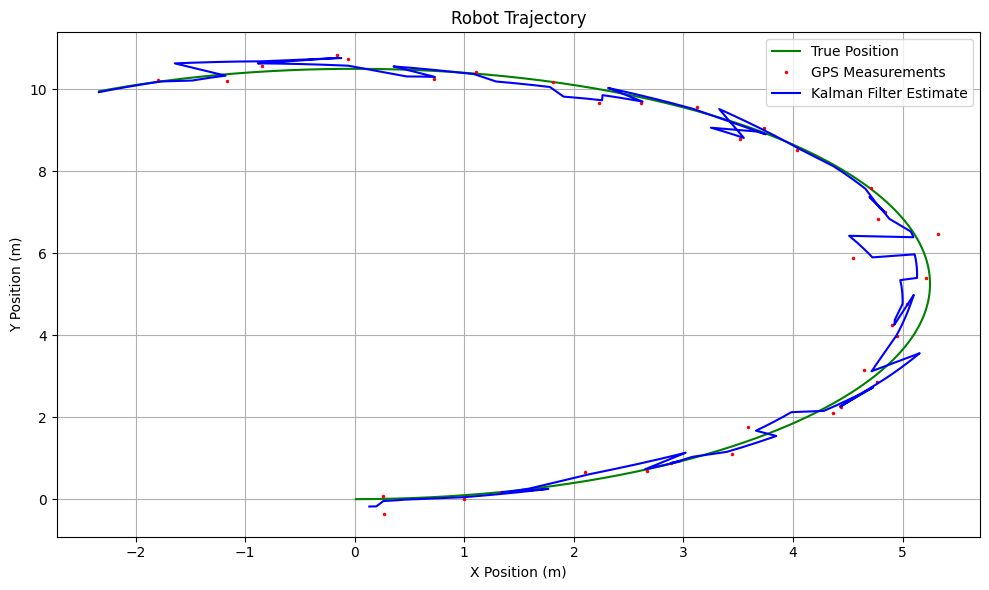

In [83]:
simulate_robot_with_kalman_filter()